In [1]:
import os, multiprocessing, cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from libvisu import *
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers

All images have been preloaded locally!


## Configuration

In [2]:
# Path to the folder containing the pictures
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/24.09-24.10_observation_OH/Images/'                        # For images
rootpath_data = '/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/ABC/ABCVisualisation/data/2024-12-05_11-38_influxdb_data.csv'  # For CO2, htr and tmp data
hive = "2"
t_res = "1min" # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.

first_dt = "241120-120000Z"
#last_dt = "241205-101000Z"
last_dt = "241120-170000Z"

frame_drop = 10 # We keep 1 frame every frame_drop frames. Put one to keep all frames.

HiveSnapshot.resize_factor = 10.1 # Resize factor for the thermal images relative to the IR images
HiveSnapshot.inter_htr_dist = 25 # Distance between heaters in pixels
HiveSnapshot.htr_shift_x = 260 # Shift in x direction of the heaters in pixels
HiveSnapshot.htr_shift_y = 570 # Shift in y direction of the heaters in pixels
HiveSnapshot.htr_size=(800,800) # Size of the heaters in pixels (width, height)

## Running

#### Image fetching

In [3]:
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=pd.to_datetime(first_dt, format='%y%m%d-%H%M%S%z'), end=pd.to_datetime(last_dt, format='%y%m%d-%H%M%S%z'), freq=t_res)
datetimes = datetimes[::frame_drop]

# Get the list of folders in the rootpath
paths = [os.path.join(rootpath_imgs, f) for f in os.listdir(rootpath_imgs) if os.path.isdir(os.path.join(rootpath_imgs, f))]
paths = [path for path in paths if "h"+hive in path]
rpis = [path.split("/")[-1][3] for path in paths]

# Order the paths alphabetically
paths.sort() # Now this contains the path to all RPis images

# For each dt in datetimes, find the image path that == dt for each RPi. Put the paths in a df where each row is a dt and each column is a RPi
imgs_paths = pd.DataFrame(index=datetimes, columns=[os.path.basename(path)[:4] for path in paths])
for dt in datetimes:
    for path in paths:
        filename = "hive"+hive+"_rpi"+path.split("/")[-1][3]+"_"+dt.strftime('%y%m%d-%H%M')
        # Find the file in os.listdir(path) that contains the dt (or startswith(dt))
        img_path = [os.path.join(path, f) for f in os.listdir(path) if filename in f]
        if len(img_path) == 1:
            imgs_paths.loc[dt, os.path.basename(path)[:4]] = img_path[0]
        else:
            imgs_paths.loc[dt, os.path.basename(path)[:4]] = None

# Check how many images are missing
print("Missing images: ", imgs_paths.isnull().sum().sum())

Missing images:  0


#### tmp fetching

In [4]:
# We fetch the thermal and other sensory data from the hive, for both RPis.
all_data = prepareData(rootpath_data)                   # All data in the csv nicely formatted
hive_data = extractData(all_data, int(hive), datetimes) # Restricted to our time frame and hive
upper, lower = generateThermalDF(hive_data,datetimes)   # Only tmp data, in a format that can be used by ThermalFrame
# Seek the max and min values of the tmp data, in both upper and lower hives
max_temp = max(upper.max().max(), lower.max().max())
min_temp = min(upper.min().min(), lower.min().min())
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(upper)

Max temperature in the selected time range:  28.9765625
Min temperature in the selected time range:  11.240885416666666
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21        t22        t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59        t60        t61        t62        t63   
2024-11-20 12:00:00+00:00  22.513021  21.126302  20.539062  18.144531  22.338542  23.684896  27.682292  25.760417  21.031250  18.292969  18.929688  21

#### Metabolic data fetching

In [5]:
# Now we fetch the metabolic data
co2_data =generateMetabolicDF(hive_data)
print(co2_data)

                               ul            ur           ll            lr     
_time                                                                          
2024-11-20 12:00:00+00:00  3177.219833   3851.666667  2119.651500    343.166667
2024-11-20 12:10:00+00:00  3602.839167   2210.500000  1449.195333    664.000000
2024-11-20 12:20:00+00:00  4027.940667   6282.500000   929.277017    326.500000
2024-11-20 12:30:00+00:00  4030.718500  13102.833333  1460.446500    654.500000
2024-11-20 12:40:00+00:00  4624.775000   8399.833333  2448.155333    573.833333
2024-11-20 12:50:00+00:00  4067.230000  10429.500000  2496.427333    519.333333
2024-11-20 13:00:00+00:00  2953.520500  16237.833333  1829.904667    727.500000
2024-11-20 13:10:00+00:00  3177.838333   9413.200000  1090.849000    457.200000
2024-11-20 13:20:00+00:00  2403.935833  14747.800000  1106.431000    395.200000
2024-11-20 13:30:00+00:00  2770.734667  20862.000000  1530.880167   2138.666667
2024-11-20 13:40:00+00:00  3854.377500  

#### htr fetching

In [6]:
# Alternative used now:
upper_htr = hive_data[(hive_data["inhive_loc"] == "upper") & (hive_data["_measurement"] == "htr")]
lower_htr = hive_data[(hive_data["inhive_loc"] == "lower") & (hive_data["_measurement"] == "htr")]
# Drop the _measurement column
upper_htr = upper_htr.drop(columns=["_measurement"])
lower_htr = lower_htr.drop(columns=["_measurement"])
print(upper_htr)

                                    _time              _value     _field   board_id  hive_num inhive_loc          mcu_uuid           rpi_num valid actuator_instance
_time                                                                                                                                                               
2024-11-20 12:00:00+00:00 2024-11-20 12:00:00+00:00   20.000000        obj   abc02       2       upper    2191218169584597824190002     1      NaN         h09      
2024-11-20 12:00:00+00:00 2024-11-20 12:00:00+00:00   20.000000        obj   abc02       2       upper    2191218169584597824190002     1      NaN         h05      
2024-11-20 12:00:00+00:00 2024-11-20 12:00:00+00:00   19.830730   avg_temp   abc02       2       upper    2191218169584597824190002     1      NaN         h05      
2024-11-20 12:00:00+00:00 2024-11-20 12:00:00+00:00    1.000000  is_active   abc02       2       upper    2191218169584597824190002     1      NaN         h04      
2024-11-20

#### Plotting

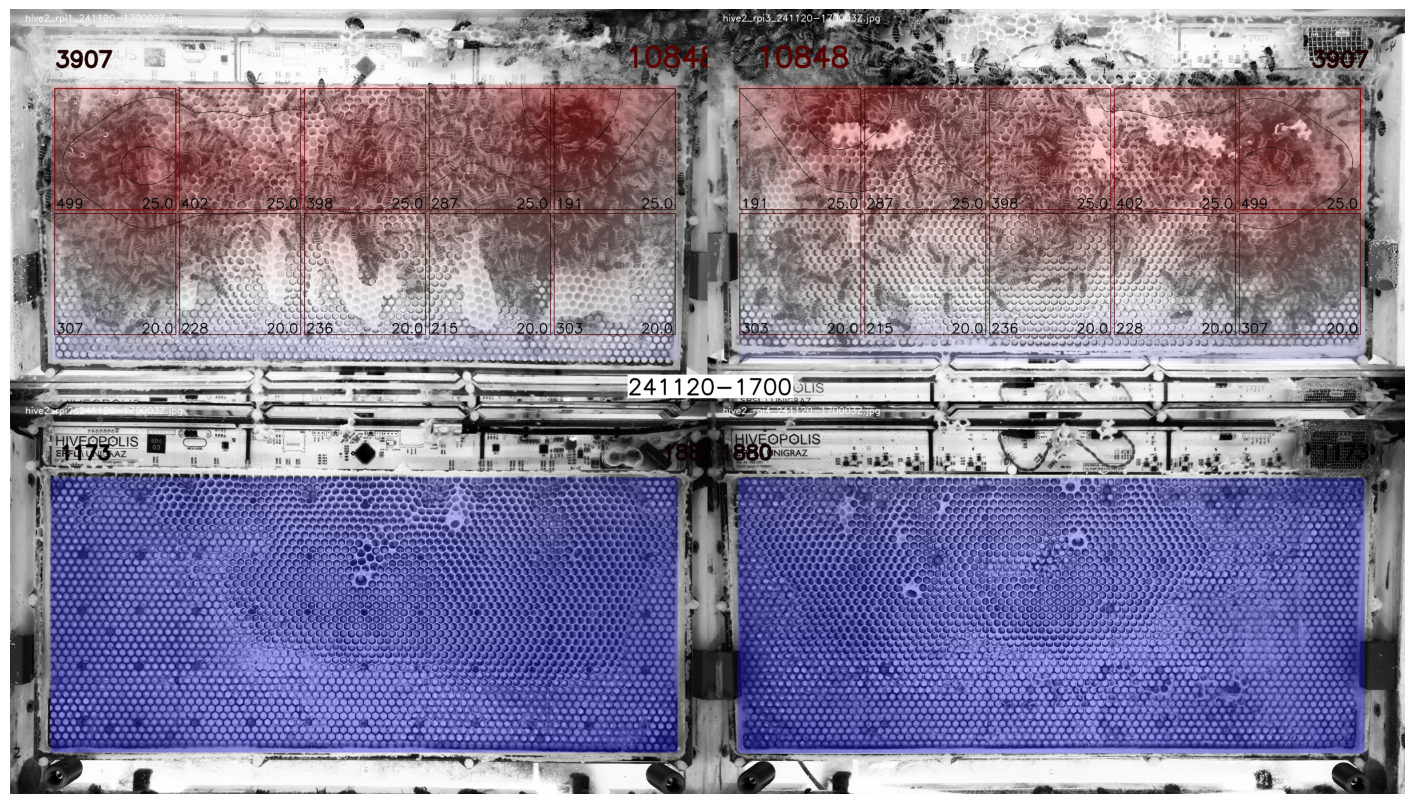

In [7]:
vmax = max_temp
vmin = min_temp
# For a random time frame, generate the image of the hive and the thermal plot side by side with matplotlib
# This is just to check that everything is working fine
plt.figure(figsize=(18, 12))
frame = 30 # Frame within datetimes
dt = datetimes[frame]
_imgs_paths = imgs_paths.loc[dt].to_numpy()
imgs_names = [str(_imgs_paths[i]).split("/")[-1] for i in range(len(_imgs_paths))]
# Read the images using cv2
current_imgs = [cv2.imread(_imgs_paths[i], cv2.IMREAD_GRAYSCALE) if _imgs_paths[i] is not None else np.zeros((2592,4608), np.uint8) for i in range(len(_imgs_paths))]

hs_1 = HiveSnapshot(current_imgs,imgs_names,ThermalFrame(upper.loc[dt].to_numpy()),ThermalFrame(lower.loc[dt].to_numpy()),co2_data.loc[dt],upper_htr.loc[dt],lower_htr.loc[dt])
snapshot = hs_1.snapshot(v_max=vmax,v_min=vmin,contours=[24, 26],thermal_transparency=0.35)
plt.imshow(snapshot,cmap='gray')
plt.axis('off') 
plt.show()

#### Automation

In [ ]:
final_imgs = []
print("Generating frames...")
for dt in tqdm(datetimes):
    _imgs_paths = imgs_paths.loc[dt].to_numpy()
    imgs_names = [str(_imgs_paths[j]).split("/")[-1] for j in range(len(_imgs_paths))]
    # Read the images using cv2
    current_imgs = []
    for _img_path in _imgs_paths:
        if _img_path is not None:
            img = cv2.imread(_img_path, cv2.IMREAD_GRAYSCALE)
            current_imgs.append(img)
        else:
            current_imgs.append(np.zeros((2592,4608), np.uint8))
            
    hs = HiveSnapshot(current_imgs, imgs_names, ThermalFrame(upper.loc[dt].to_numpy()), ThermalFrame(lower.loc[dt].to_numpy()), co2_data.loc[dt], upper_htr.loc[dt], lower_htr.loc[dt])
    snapshot = hs.snapshot(v_max=vmax, v_min=vmin)
    final_imgs.append(snapshot)

# Change frames from rgb to bgr
print("Convert frames to bgr...")
for i in tqdm(range(len(final_imgs))):
    final_imgs[i] = cv2.cvtColor(final_imgs[i], cv2.COLOR_RGB2BGR)

dest = "outputVideos/"
# Make this a global path
print("Saving video...")
generateVideoFromList(final_imgs, dest="outputVideos/", name="hive" + hive + "_" + first_dt + "_" + last_dt, fps=10, grayscale=False)

# Cleanup step to release resources
multiprocessing.active_children()

Generating frames...


  3%|▎         | 1/31 [00:01<00:38,  1.29s/it]